## Coral Paleoclimate Practical #1 - Data analysis and comparision to Cliamte

This worksheet will go through the basics of coral paleoclimate and basics of python. We will assume no knowledge of python however there are some basics that will help (these would be resources for fututre!); 
- 10 minutes into pandas - https://pandas.pydata.org/docs/user_guide/10min.html#min
- what is xarray - https://tutorial.xarray.dev/overview/xarray-in-45-min.html
- some great xarray examples - https://docs.xarray.dev/en/stable/gallery.html

Some good paleoclimate specific pages; 
- Pyleoclim - https://pyleoclim-util.readthedocs.io/en/latest/

Other free resources; 
- Earth Lab - https://www.earthdatascience.org/courses/use-data-open-source-python/
- ARC Center for Excellence and climate extremes - https://climate-cms.org/index.html

First things first we have to import anything that may be relevant to this tutorial, meaning the important packages

Tips for this, to make sure that cells (each box here is called a cell) are run, you click on each and then either press 'Shift+enter' or the run button at the top.

In [3]:
import pyleoclim as pyleo #this is the paleoclimate python model -- May not use this 
import xarray as xr #xarray is the processing package that helps deal with large datasets (often gridded data)
import pandas as pd #this is the main python package that deals with open source data analysis and manipulation


import sys #this is a module that provides various functions and variables
import numpy as np
from netCDF4 import num2date
from statsmodels.tsa.seasonal import seasonal_decompose

import cftime #this is a time related pacakge

# this is all for plotting...
import matplotlib as mpl #mapping and plotting package
import matplotlib.pyplot as plt
%matplotlib inline

import cartopy #this is another mapping package
import datetime
from datetime import date, datetime, timedelta   # to convert "days since XXX" to date

#this is all for the stats 

from scipy.signal import find_peaks
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import linregress
import statsmodels.api as sm

from pylr2 import regress2 

We can test this worked by making the notebook do something;

In [4]:
print ('Hello, welcome to this practical!')

# python works on a zero based system (i.e. the numbering starts from 0) and the system works fairly simply
# if you want to test some basic maths for example 

print ('The result of 2+2 is equal to:')

2+2 

Hello, welcome to this practical!
The result of 2+2 is equal to:


4

#### Now we need to import the data that we want to work with. 

In this practical we will be using some previously published coral records, first from the tropical Pacific Island called Palmyra Island (Nurhati et al., 2011). This Palmyra Island coral lies on the edge of the NINO3.4 region, which is a popular measure of the state of El Niño Southern Oscillation. 

We will go through the basics of comparing the coral proxy (after the age model is developed like we did in the end of the last prac sheet) to SST, filtering the dataset and then comparing it to the climate. 

This papers can be found in the github folder!

You will look at following and investigate what this means;
- relationship between coral proxy evidence and sea surface temperature, 
- relationships between the coral proxies and large climate oscillations
- correlations to gridded fields 

## 1. How well do corals in the tropical Pacific reconstruct Sea surface temperature?



The data is in the same folder we are working in so we can just download it straight into this box using a excel read comment.


In [5]:
#we want to upload the coral data here and name it something meaningful
# this function 'pd.read_excel' will read the document and put it into a pandas array
NU11_palmyra = pd.read_excel('palmyra2011.xlsx') 

# we can print this out by just typying our meaningful name again

NU11_palmyra

,Decimal_Date,SrCa
0,1886.13,9.0082
1,1886.21,9.0200
2,1886.29,8.9800
3,1886.38,8.9891
4,1886.46,8.9967
...,...,...
1342,1997.96,8.9167
1343,1998.04,8.9367
1344,1998.13,8.9120
1345,1998.21,8.9000


One thing to notice here is that the date format is in a decimal (i.e. 1886.13 is equivalent to the middle of February in 1886). In order to more easily manipulate the dates we would like to use something called Datetime. This will allow us to compare the data easily and average the data to annual values etc. 

- see more about datetime here - https://docs.python.org/3/library/datetime.html

In [6]:
# We can create a date_range using the function pd.date_range (https://pandas.pydata.org/docs/reference/api/pandas.date_range.html)
# which will range from the starting date (1886.13) middle of Feb, for the entire length of the pandas array.
Datetime=(pd.date_range(start='1/2/1886', periods=1347, freq='MS'))+ pd.offsets.Day(14) 

# here MS means the month start, and we offset it by 14 days to make it the middle of the month
Datetime # again we can print it out to see what we have done. 

DatetimeIndex(['1886-02-15', '1886-03-15', '1886-04-15', '1886-05-15',
               '1886-06-15', '1886-07-15', '1886-08-15', '1886-09-15',
               '1886-10-15', '1886-11-15',
               ...
               '1997-07-15', '1997-08-15', '1997-09-15', '1997-10-15',
               '1997-11-15', '1997-12-15', '1998-01-15', '1998-02-15',
               '1998-03-15', '1998-04-15'],
              dtype='datetime64[ns]', length=1347, freq=None)

In [7]:
# We can then add this into the pandas array so we have it all in the same place
NU11_palmyra['Datetime'] = Datetime #this just adds another column to the data
NU11_palmyra

,Decimal_Date,SrCa,Datetime
0,1886.13,9.0082,1886-02-15
1,1886.21,9.0200,1886-03-15
2,1886.29,8.9800,1886-04-15
3,1886.38,8.9891,1886-05-15
4,1886.46,8.9967,1886-06-15
...,...,...,...
1342,1997.96,8.9167,1997-12-15
1343,1998.04,8.9367,1998-01-15
1344,1998.13,8.9120,1998-02-15
1345,1998.21,8.9000,1998-03-15


So far we have been working with a very useful python package called pandas. The above table is called a pandas DataFrame. However when we are working with climate data it is easier to work with a package called an xarray (we will also use some pyleoseries data later). Xarray allows us to compare to gridded data much easier, and manipulate the data effectively. 


We need to convert this Pandas series into a xarray Dataset. 

In [8]:
# this code creates an xarrary Dataset, with the Palmyra SrCa data sorted by the datetime index we have made 
# It also includes the time information from the original dataset in the above DataFrame

NU11_palmyra_xr = xr.Dataset({'SrCa':(['Datetime'],NU11_palmyra.SrCa)},
                     attrs=dict(description="Palmyra 2011 Nurhati coral, at Palmyra: 5°53'N, 162°5'W, 9m depth"),
                   coords={'Decimal_Date':NU11_palmyra.Decimal_Date, 'Datetime':NU11_palmyra.Datetime})
# we can also add in information about the location and the coral
NU11_palmyra_xr #this will let us print this information

<xarray.Dataset>
Dimensions:       (Datetime: 1347, Decimal_Date: 1347)
Coordinates:
  * Decimal_Date  (Decimal_Date) float64 1.886e+03 1.886e+03 ... 1.998e+03
  * Datetime      (Datetime) datetime64[ns] 1886-02-15 1886-03-15 ... 1998-04-15
Data variables:
    SrCa          (Datetime) float64 9.008 9.02 8.98 8.989 ... 8.912 8.9 8.96
Attributes:
    description:  Palmyra 2011 Nurhati coral, at Palmyra: 5°53'N, 162°5'W, 9m...

### We can plot up the Sr/Ca data really easily! This way we can see what we are working with. 

<function matplotlib.pyplot.show(close=None, block=None)>

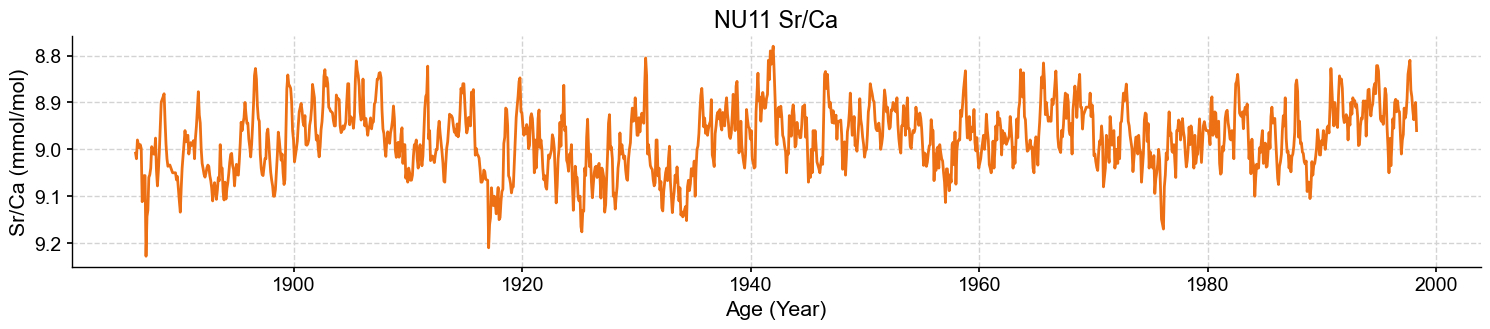

In [9]:
fig = plt.figure(figsize=(40, 3)) # this creates a figure of the size that we want to look at

ax = fig.add_subplot(1, 2, 1) #this adds subplots (which we wont really use, but good for the future!)

ax.plot(NU11_palmyra_xr.Datetime, NU11_palmyra_xr.SrCa, color = '#ED7014') # this plots the date on the x-axis and
# Sr/Ca on the y - axis

plt.gca().invert_yaxis() #this just inverts the y-axis, because we know that Sr/Ca is inversely related to SST and this makes more sense

ax.set_ylabel('Sr/Ca (mmol/mol)', color= 'black') #set a y-label
ax.set_xlabel('Age (Year)', color= 'black') #set a x-label
ax.set_title('NU11 Sr/Ca') #set a title

plt.show

### Now we want to upload the SST data in order to compare SST at the location with the Sr/Ca values.

There are a number of different SST products we could use, however, we will use this one as the original paper says that the in-situ SST in the region best corresponds to the Reynolds SST dataset which is an older version of OISST.

I have already segmented the SST for you, and selected it from the OISST dataset (Huang et al., 2021), this SST dataset is for the box surrounding where the coral is located. 

- you can read about OISST here - https://www.ncei.noaa.gov/products/optimum-interpolation-sst


In [10]:
OISST_palmyra = xr.open_dataset('NU11_palmyra_OISST.nc') # this is how we open a netcdf4 file into an xarray dataset 

OISST_palmyra #again we can just print it here to see what the OISST data looks like



<xarray.Dataset>
Dimensions:  (time: 200)
Coordinates:
  * time     (time) datetime64[ns] 1981-09-01 1981-10-01 ... 1998-04-01
Data variables:
    sst      (time) float32 ...
Attributes:
    description:  OISSTv2

<function matplotlib.pyplot.show(close=None, block=None)>

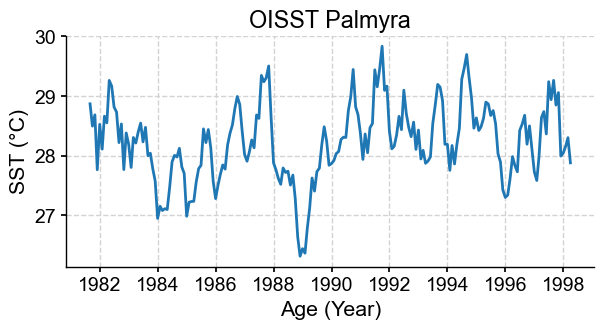

In [11]:
# we can also plot this to see what it looks like 
fig = plt.figure(figsize=(15, 3)) # this creates a figure of the size that we want to look at

ax = fig.add_subplot(1, 2, 1)

ax.plot(OISST_palmyra.time, OISST_palmyra.sst) # this plots the date on the x-axis and SST on the y-axis

ax.set_ylabel('SST (°C)', color= 'black') #set the y label
ax.set_xlabel('Age (Year)', color= 'black') #set the x label
ax.set_title('OISST Palmyra') # set the title

plt.show

## Testing the relationship using correlations

Okay now that we have the coral data and the sst in this notebook we want to look at how well the two datasets relate to each other. We can do this by testing the correlation between the two datasets. 

We will look at Sr/Ca of the coral, related to SST. There are a number of ways to do this, and a number of things to think about (like autocorrelation and lag of the dataset) but we are going to ignore that for the moment. You can read more about that elsewhere. 

To look at the two datasets we need them to be the same length. At the moment the coral spans from 1882-1998 and the SST only covers the instrumental period of the coral (1981-1998). 

- So we have to shorten the coral.


In [12]:
startyr = 1981 # Starting this on the same time frame at OISST. OISST starts at the 1/9/1981
endyr = 1998  # the end of the coral period. I have already shorted the SST for you

t1 = datetime(startyr, 9, 1)     #we can set the month and date here
t2 = datetime(endyr, 5, 1)       #we can set the month and date here

# and a function in the xarray package allows us to slice. This is the .sel function, allowing slices along a coordinate
NU11_palmyra_short = NU11_palmyra_xr.sel(Datetime=slice(t1, t2)) 

NU11_palmyra_short #print this out

<xarray.Dataset>
Dimensions:       (Datetime: 200, Decimal_Date: 1347)
Coordinates:
  * Decimal_Date  (Decimal_Date) float64 1.886e+03 1.886e+03 ... 1.998e+03
  * Datetime      (Datetime) datetime64[ns] 1981-09-15 1981-10-15 ... 1998-04-15
Data variables:
    SrCa          (Datetime) float64 8.917 8.943 8.957 8.978 ... 8.912 8.9 8.96
Attributes:
    description:  Palmyra 2011 Nurhati coral, at Palmyra: 5°53'N, 162°5'W, 9m...

<function matplotlib.pyplot.show(close=None, block=None)>

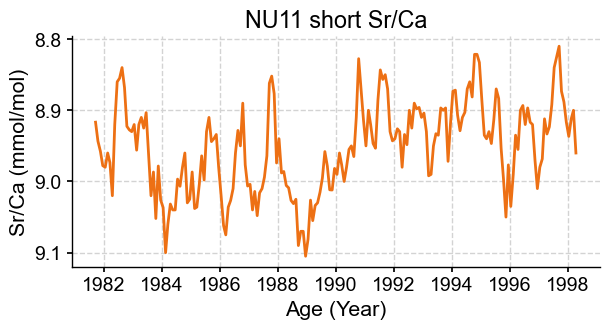

In [13]:
# we can also plot this to see what the shortened coral looks like 

fig = plt.figure(figsize=(15, 3)) # this creates a figure of the size that we want to look at

ax = fig.add_subplot(1, 2, 1)

ax.plot(NU11_palmyra_short.Datetime, NU11_palmyra_short.SrCa, color = '#ED7014') # this plots the date on the x-axis and
# Sr/Ca on the y - axis
plt.gca().invert_yaxis()

ax.set_ylabel('Sr/Ca (mmol/mol)', color= 'black') 
ax.set_xlabel('Age (Year)', color= 'black')
ax.set_title('NU11 short Sr/Ca')
plt.show

In [14]:
# we can just print the length of both to check they are the same, 
# and you can check that the two start at the same time youself
print ('the length of the short coral is - '+ str(len(NU11_palmyra_short.Datetime)))
print ('the length of the SST is - '+ str(len(OISST_palmyra.time)))

the length of the short coral is - 200
the length of the SST is - 200


To test the correlations we do need to use a correlation function. The best way to do this is actually to transfer the data into a different datatype called a pyleo series. You can check out more informatino about it here if you want (https://pyleoclim-util.readthedocs.io/en/latest/index.html). 

The reason we use this is that they have a really nice function which allows us to account for the autocorrealtion of datasets (this is often the case in monthly climate data), by calculating the correlation and p-value through an n-effective number. We can talk about this more, but won't have time to go into it here! 

In [15]:
# The next two lines transfer the xarray datasets into the pyleo series. It takes the time, and the values into a series
NU11_palmyra_shortpy = pyleo.Series(time=NU11_palmyra_short['Datetime'],value=NU11_palmyra_short['SrCa'],time_name='Years CE',value_name='d18O')
OISST_py = pyleo.Series(time=OISST_palmyra['time'],value=OISST_palmyra['sst'],time_name='Years CE',value_name='SST', clean_ts=False)

# now we calculate the correlation. By using the pyleo series called NU11_palmyra_shortpy and calling the function
# corraltion. We correlatte this with OISST_py using a ttest method. This method takes into account the autocorrelation.
SST_corr = NU11_palmyra_shortpy.correlation(OISST_py, settings={'method':'ttest'})

print ('---------------------------------------------')
print ('The corre between the Palmyra coral Sr/Ca and OISST')
print (str(SST_corr)) # this prints the correlations, pvalue and significance. They print this whole thing because it 
                      # is built into the correlation function


---------------------------------------------
The corre between the Palmyra coral Sr/Ca and OISST
  correlation  p-value    signif. (α: 0.05)
-------------  ---------  -------------------
     -0.75399  < 1e-5     True



# Q1. What does this correlation mean?

- is this strong? 
- is this inverse or not?

-- You can write any notes here!

## We can also calibrate the coral with SST 

When we calibrate the coral, we have to deteremine the slope value of the regression between SST and Sr/Ca. This would allow us to compare to other coral records. 

There are a number of different regression methods. The most common method is the ordinary least squares method, however there are other methods which review papers suggest should be used, such as reduced major axis or weighted least square methods (WLS). WLS is the most recommended method however we dont have errors today so we won't be using this method.  

Today we will be using the reduced major axis method, reduced major axis (RMA) regression is specifically formulated to handle errors in both the x and y variables - read more here. https://wires.onlinelibrary.wiley.com/doi/full/10.1002/wcc.745

#### We will use a package called regress2 which has a reduced major axis method. We can regress the SST and the coral Sr/Ca against each other and then plot the data in a scatter plot

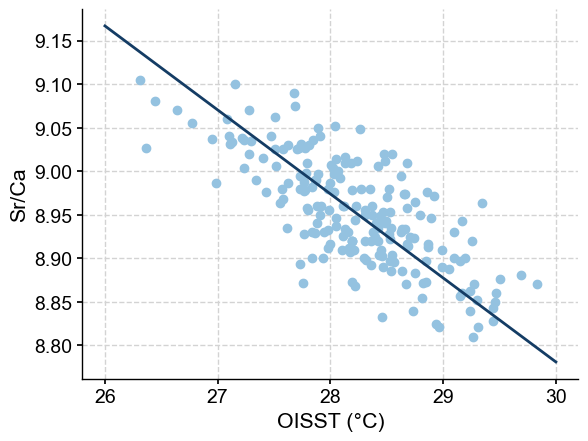

bimonthly ERSST and MAU1 WLS
---------------------------
The slope between ERSST and SrCa -0.09646042143744483
The slope error between ERSST and SrCa 0.004988799066966241
The intercept between ERSST and SrCa 11.674835763336684
The intercept error between ERSST and SrCa 0.1408274803392929


In [16]:
# this calls the regres2 method, using the OISST and Sr/Ca data with method RMA
# this method results in a slope, the standard deviation of the slope, the intercept and the standard deviation of this
results = regress2(OISST_palmyra.sst.values,NU11_palmyra_short.SrCa.values, _method_type_2="reduced major axis")

# we will also create a fake dataset in order to plot the trend line of the dataset
x = np.linspace(26,30,100) #this creates an empty array of x between 26-30 of the SST
y = (results['slope'])*x+results['intercept'] #this creates a y axis for the trend, based on the slope/intercept of the above results.

#this scatter plot of the SST and Sr/Ca
plt.scatter(OISST_palmyra.sst.values,NU11_palmyra_short.SrCa.values,c= '#94c2e0')
#this would plot the trend line we just made
plt.plot(x, y, '#143c64', label='y=2x+1')


plt.xlabel('OISST (°C)') # set the x-label
plt.ylabel('Sr/Ca') # set the y-label

plt.show()

# we are printing all the values of the slope and intercept etc. 
print ('bimonthly ERSST and MAU1 WLS')
print ('---------------------------')

print ("The slope between ERSST and SrCa " + str(results['slope']))
print ("The slope error between ERSST and SrCa " + str(results['std_slope']))
print ("The intercept between ERSST and SrCa " + str(results['intercept']))
print ("The intercept error between ERSST and SrCa " + str(results['std_intercept']))


# Q2. What do these values mean?

Have a go at thinking about what these values mean? You can write this in the box below..

- some hints, what does the correlation mean? what does the slope mean etc. 
- what is the relationship between SST and Sr/Ca in the coral at Palmyra



-- You can write any notes here!

# ------------------------------------------------------------------------------------------

# Section 2. Okay what makes up the values in the time series?
## Climate time series are made up generally of the seasonal data, and a trend component. 

We know that Sr/Ca is related to SST and from this we can split the time series up into a component which is the trend, and a second which is the seasonality. The two additions of these componenets (seasonality and trend) is called additive seasonality. 

We can pull these out and say what component is related to each it allows us to do a number of things; 

- look at what sort of trend is in our data, i.e. how much the temperature has increased?
- look at what component of the data is related to the seasonality

### First off we are going to convert our Sr/Ca into SST, because what we care about is the change in SST. The best way to do this is to first center the Sr/Ca data around 0 and then scale to SST. 

- this is because it is not the best practice to convert directly to SST.

- to do this we remove the mean, effectively calculating anomalies relative to the climatology

In [17]:
# First off we have to calculate the climatology of the NU11. Because our xarray dataset has the datetime we can use 
# this to calculating the climatology (climatology is the average of each month)

# this is a groupby function, grouping by the month, and then averaging across this month.
climatology_NU11 = NU11_palmyra_xr.groupby('Datetime.month').mean('Datetime') 


# we can use this groupby, and then remove climatology we just made above!
NU11_palmyra_xr['centered_NU11'] = NU11_palmyra_xr.SrCa.groupby('Datetime.month') - climatology_NU11.SrCa

#and print this
NU11_palmyra_xr



<xarray.Dataset>
Dimensions:        (Datetime: 1347, Decimal_Date: 1347)
Coordinates:
  * Decimal_Date   (Decimal_Date) float64 1.886e+03 1.886e+03 ... 1.998e+03
  * Datetime       (Datetime) datetime64[ns] 1886-02-15 ... 1998-04-15
    month          (Datetime) int64 2 3 4 5 6 7 8 9 10 ... 8 9 10 11 12 1 2 3 4
Data variables:
    SrCa           (Datetime) float64 9.008 9.02 8.98 8.989 ... 8.912 8.9 8.96
    centered_NU11  (Datetime) float64 -0.001616 0.01323 ... -0.1068 -0.03615
Attributes:
    description:  Palmyra 2011 Nurhati coral, at Palmyra: 5°53'N, 162°5'W, 9m...

And we want to print this out to just see what it looks like.

<function matplotlib.pyplot.show(close=None, block=None)>

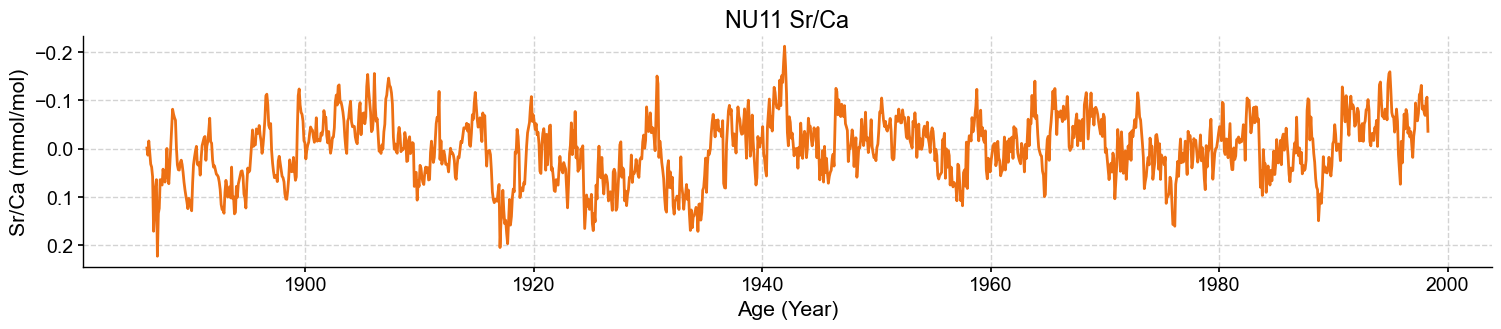

In [18]:
fig = plt.figure(figsize=(40, 3)) # this creates a figure of the size that we want to look at

ax = fig.add_subplot(1, 2, 1)

#Here we plot the Datetime and the centered NU11
ax.plot(NU11_palmyra_xr.Datetime, NU11_palmyra_xr.centered_NU11, color = '#ED7014') 

plt.gca().invert_yaxis() # this flips the y-axis

ax.set_ylabel('Sr/Ca (mmol/mol)', color= 'black') 
ax.set_xlabel('Age (Year)', color= 'black')
ax.set_title('NU11 Sr/Ca')

plt.show

#### Now we can use this centered data to convert to SST. Because it is centered we dont have to worry about the intercept. Here we just divde the centered data by the slope, which is -0.096.

In [19]:
# This creates our SrCa_SST data
SST_derived = (NU11_palmyra_xr.centered_NU11)/-0.096

NU11_palmyra_xr['SrCa_SST'] = SST_derived # this then adds this new SST derived as a variable in the xarray

NU11_palmyra_xr


<xarray.Dataset>
Dimensions:        (Datetime: 1347, Decimal_Date: 1347)
Coordinates:
  * Decimal_Date   (Decimal_Date) float64 1.886e+03 1.886e+03 ... 1.998e+03
  * Datetime       (Datetime) datetime64[ns] 1886-02-15 ... 1998-04-15
    month          (Datetime) int64 2 3 4 5 6 7 8 9 10 ... 8 9 10 11 12 1 2 3 4
Data variables:
    SrCa           (Datetime) float64 9.008 9.02 8.98 8.989 ... 8.912 8.9 8.96
    centered_NU11  (Datetime) float64 -0.001616 0.01323 ... -0.1068 -0.03615
    SrCa_SST       (Datetime) float64 0.01683 -0.1379 0.1683 ... 1.112 0.3766
Attributes:
    description:  Palmyra 2011 Nurhati coral, at Palmyra: 5°53'N, 162°5'W, 9m...

#### Now we can plot this again! 

<function matplotlib.pyplot.show(close=None, block=None)>

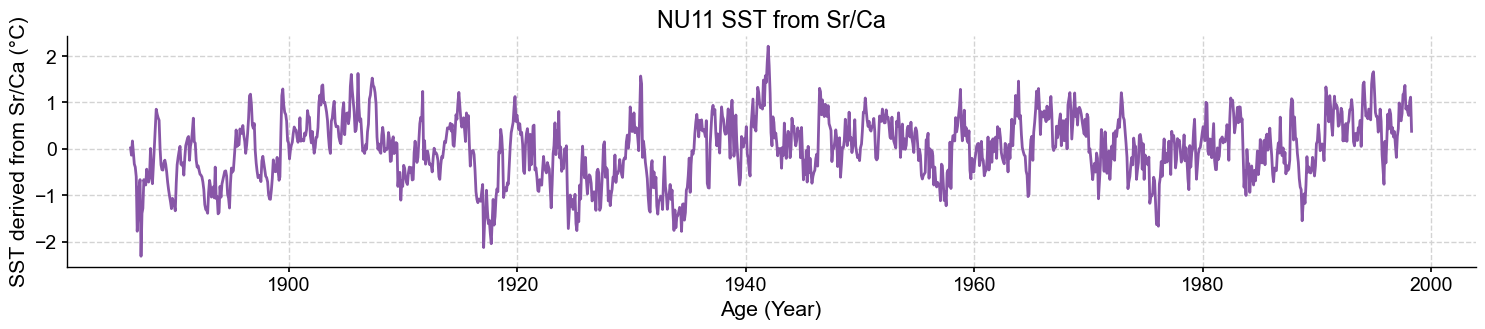

In [20]:
fig = plt.figure(figsize=(40, 3)) # this creates a figure of the size that we want to look at

ax = fig.add_subplot(1, 2, 1)

ax.plot(NU11_palmyra_xr.Datetime, NU11_palmyra_xr.SrCa_SST, color = '#8856a7')

# In this one we dont have to invert the axis!

ax.set_ylabel('SST derived from Sr/Ca (°C)', color= 'black') 
ax.set_xlabel('Age (Year)', color= 'black')
ax.set_title('NU11 SST from Sr/Ca')

plt.show


We could do this manually, however this would take a while but basically we can split our data into the following; 

            Y[t] = T[t] + S[t] + e[t]

    - Y[t]: Our time-series function
    - T[t]: Trend (general tendency to move up or down)
    - S[t]: Seasonality (cyclic pattern occurring at regular intervals)
    - e[t]: Residual (random noise in the data that isn’t accounted for in the trend or seasonality

There is a handing function ins the statsmodels package that we downloaded earlier which will help us look at the data. It requires data in a pandas format (which is what we have above), and it to be linked to a datetime object (which we just checked).

Text(0, 0.5, 'Residual')

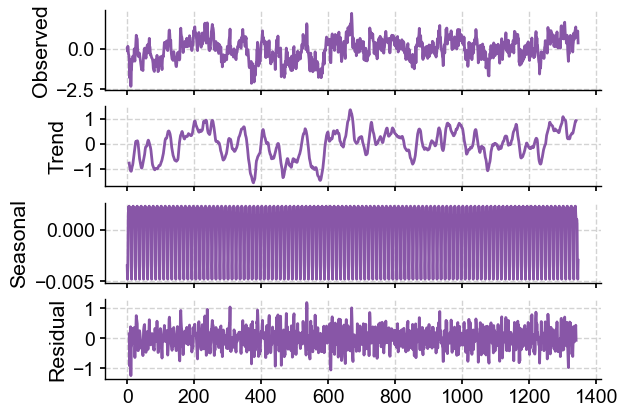

In [21]:
#the below does it for us! We input into the seasonal_decompose(data, model = "additive", period = 'the required')
decomposition= seasonal_decompose(NU11_palmyra_xr.SrCa_SST.values, model="additive", period =12)

observed = decomposition.observed
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid


fig, axes = plt.subplots(4, 1, sharex=True,dpi=100)

axes[0].plot(observed, color='#8856a7')
axes[0].set_ylabel('Observed')
axes[1].plot(trend, color='#8856a7')
axes[1].set_ylabel('Trend')
axes[2].plot(seasonal, color = '#8856a7')
axes[2].set_ylabel('Seasonal')
axes[3].plot(residual, color='#8856a7')
axes[3].set_ylabel('Residual')


### Lets plot that trend again so we can see whats happening!

<function matplotlib.pyplot.show(close=None, block=None)>

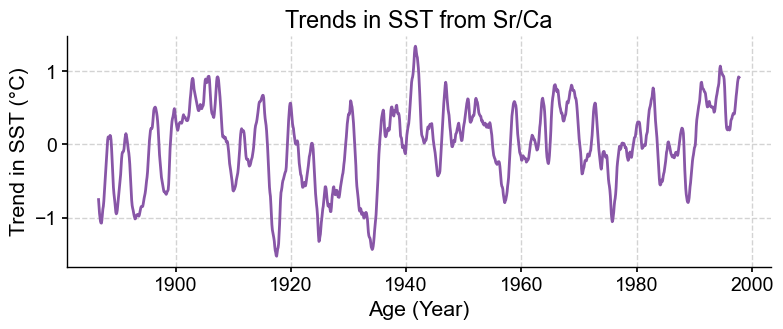

In [22]:
fig = plt.figure(figsize=(20, 3)) # this creates a figure of the size that we want to look at


ax = fig.add_subplot(1, 2, 1)

ax.plot(NU11_palmyra_xr.Datetime, trend, color = '#8856a7') # this plots the date on the x-axis and
# Sr/Ca on the y - axis

# plt.gca().invert_yaxis()

ax.set_ylabel('Trend in SST (°C)', color= 'black') 
ax.set_xlabel('Age (Year)', color= 'black')
ax.set_title('Trends in SST from Sr/Ca')

plt.show

### Q3. What does a trend like this mean?

- is SST increasing or decreasing since the start of the coral record?

Write it in the box below.

you can write here ---- 

# ------------------------------------------------------------------------------------------

# Section 3. So now we know that the Sr/Ca relates well to SST; 

- we can explore how well the SST (the Sr/Ca from the Palmyra location) relates to ENSO, so that this coral can then be used to reconstruct ENSO like is explained in the paper. 

To do this we need to look at the interannual variability of SST (Sr/Ca). ENSO is a climate phenomena which operates on interannual timescales (2-7yr), and therefore the best way to compare the ENSO indices (NINO3.4, SOI etc.) to SST at a location is to extract the interannual variability. 

To do this we can use something called a bandpass filter. A bandpass filter is basically used to filter a particular range of frequencies (for us the frequencies between 2-7 years), there are lots of different filters that you can use for this  but today we are going to use a butterworth filter. 

    - read more about high, low and bandpass filters here;
        - https://www.rfpage.com/low-pass-high-pass-and-band-pass-filters-simple-explanation/
        
#### What is cool is that the pyleoclim package makes this filtering process really easy! 


### First we have to make a pyleo series of the anomalies that we calculated earlier in the xarray dataset

- we want to use the anomalies because we are looking at the changes in Sr/Ca related to the ENSO signal

- we want to make a pyleo series because we will correlation the different datasets, and we want to do some filtering.



In [23]:
NU11_palmyra_xr 

<xarray.Dataset>
Dimensions:        (Datetime: 1347, Decimal_Date: 1347)
Coordinates:
  * Decimal_Date   (Decimal_Date) float64 1.886e+03 1.886e+03 ... 1.998e+03
  * Datetime       (Datetime) datetime64[ns] 1886-02-15 ... 1998-04-15
    month          (Datetime) int64 2 3 4 5 6 7 8 9 10 ... 8 9 10 11 12 1 2 3 4
Data variables:
    SrCa           (Datetime) float64 9.008 9.02 8.98 8.989 ... 8.912 8.9 8.96
    centered_NU11  (Datetime) float64 -0.001616 0.01323 ... -0.1068 -0.03615
    SrCa_SST       (Datetime) float64 0.01683 -0.1379 0.1683 ... 1.112 0.3766
Attributes:
    description:  Palmyra 2011 Nurhati coral, at Palmyra: 5°53'N, 162°5'W, 9m...

In [24]:
#make the pyleo series of the anomalies
NU11_palmyra_anom_py=pyleo.Series(time=NU11_palmyra_xr['Decimal_Date'],value=NU11_palmyra_xr['SrCa_SST'],time_name='Years CE',value_name='d18O')




#### For some reason the date is not evenly spaced, and in order to filter the datasets we need this to be evenly spaced


In [ ]:

# we can use the bin function in pyleoseries' and we set the bin_size to a month (which is 0.083333333) and starts at the start 
NU11_palmyra_bin = NU11_palmyra_anom_py.bin(bin_size=0.083333333, start = 1886.083333333)
NU11_palmyra_bin.__dict__ # using the .__dict__ we can see what we have done

### Now we want to filter the datasets

- we filter these datasets because we want to reveal signals in the coral dataset which are related to the ENSO signal. As said before we are using a butterworth filter betwen 2 and 7 years. 

In [ ]:
NU11_palmyra_filter_but = NU11_palmyra_bin.filter(method='butterworth',cutoff_scale=[2,7])
NU11_palmyra_filter_but.__dict__

In [ ]:
# now we can plot what that looks like! 

fig, (ax1) = plt.subplots(1, figsize=(10, 4), dpi = 80, sharex=True)

ax1.plot(NU11_palmyra_filter_but.time,NU11_palmyra_filter_but.value, color = '#8856a7')

ax1.set_xlabel('Age (Year)', color= 'black')

ax1.set_title('Band-pass Butterworth filter 2-7 year Coral')


## Now we import the Nino3.4 dataset. 

- This is in the same folder so we can just import the netcdf4 file as an xarray. 
- This was downloaded from the Climate explorer website

In [ ]:
Nino3_4 = xr.open_dataset('Nino34.nc') # this is how we open a netcdf4 file into an xarray dataset 

#we can shift this into a pyleo series again, you should know what these are now! 
Nino3_4_py=pyleo.Series(time=Nino3_4['Date'],value=Nino3_4['Nino34r'],time_name='Years CE',value_name='d18O')

Nino3_4 # printing so you can look at it! 

In [ ]:
fig = plt.figure(figsize=(40, 3)) # this creates a figure of the size that we want to look at

ax = fig.add_subplot(1, 2, 1)

ax.plot(Nino3_4_py.time, Nino3_4_py.value, color = '#62BD69') # this plots the date on the x-axis and Nino3.4 on the y


ax.set_ylabel('Nino3.4', color= 'black') 
ax.set_xlabel('Age (Year)', color= 'black')
ax.set_title('Nino3.4 index')

plt.show

In [ ]:
# and now we filter this so we can compare if the signals are the same!
Nino3_4_filter_but = Nino3_4_py.filter(method='butterworth',cutoff_scale=[2,7])
Nino3_4_filter_but.__dict__

In [ ]:
# and we can plot this filtered dataset
fig, (ax1) = plt.subplots(1, figsize=(10, 4), dpi = 80, sharex=True)

ax1.plot(Nino3_4_filter_but.time,Nino3_4_filter_but.value,'#62BD69', label = 'Nino3.4 Filter')

ax1.legend()
ax1.set_title('Nino3.4 Band-pass filter, 2-7 year')


In [ ]:
# And finally we can plot the two datasets together. As they are both in anomalies we can plot on the same axis

fig, (ax1) = plt.subplots(1, figsize=(10, 4), dpi = 80, sharex=True)

ax1.plot(Nino3_4_filter_but.time,Nino3_4_filter_but.value,'#62BD69', label = 'Nino3.4 Filter')

ax1.plot(NU11_palmyra_filter_but.time,NU11_palmyra_filter_but.value, color = '#8856a7',label='NU11 bandpass filter')

ax1.legend()
ax1.set_title('NU11 & Nino3.4 Band-pass filter, 2-7 year')


#### Finally these look pretty similar, how well related are they?


In [ ]:
# You can use the same correlation function that we saw earlier!
Nino_corr =NU11_palmyra_filter_but.correlation(Nino3_4_filter_but, settings={'method':'ttest'})

print ('---------------------------------------------')
print ('The corre between the Palmyra coral Sr/Ca anomalies and Nino3.4')
print (str(Nino_corr))

## Q4. What does a relationship like this actually mean?

- Think about the strong relationship between Nino3.4 and the Coral Sr/Ca filterd
- What might that mean for this location and its relationship to ENSO

You can write your answer here ---- 